# EEG Emotion Recognition Notebook

This notebook implements a CNN+LSTM model for emotion recognition using EEG data from the GAMEEMO dataset. The code is organized into sections with explanations.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path
import re
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

## Configuration

Set up paths and hyperparameters.

In [ ]:
DATA_ROOT = Path("../data/GAMEEMO")  # User updated path
NUM_EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.001
TEST_SPLIT_RATIO = 0.2
NUM_CLASSES = 4
NUM_CHANNELS = 14
FIXED_SEQUENCE_LENGTH = 3000
MODEL_SAVE_PATH = "models/eeg_emotion_best_accuracy_model.pth"

# Early Stopping Configuration
EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.001  # For validation loss

Path("../models").mkdir(parents=True, exist_ok=True)

In [ ]:
DATA_ROOT.mkdir(parents=True, exist_ok=True)

# Download the dataset if it does not exist
if not any(DATA_ROOT.rglob("*.csv")):
    print("Downloading GAMEEMO")
    try:
        subprocess.run(
            [
                "kaggle",
                "datasets",
                "download",
                "-d",
                "sigfest/database-for-emotion-recognition-system-gameemo",
                "-p",
                str(DATA_ROOT.parent),
                "--unzip",
            ],
            check=True,
        )
    except Exception as e:
        sys.stderr.write(f"⚠️ Kaggle download failed: {e}\n")
else:
    print("Dataset already present - skipping download.")

## 1. Data Loading and Preprocessing

Define helper functions and a custom Dataset class to load and preprocess EEG data.

In [3]:
def g_label(fn_name):
    """Extracts game label (0-3) from a filename."""
    match = re.search(r"G([1-4])", fn_name)
    if match:
        return int(match.group(1)) - 1
    raise ValueError(f"Could not extract label from {fn_name}")

class EEGDataset(Dataset):
    """Custom PyTorch Dataset for GAMEEMO EEG data."""
    def __init__(self, data_root, fixed_sequence_length, transform=None):
        self.data_root = Path(data_root)
        self.fixed_sequence_length = fixed_sequence_length
        self.transform = transform
        self.eeg_paths = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        """Loads all EEG file paths and their corresponding labels."""
        if not self.data_root.exists():
            print(f"ERROR: Data root directory '{self.data_root.resolve()}' does not exist.")
            return

        subject_count = 0
        for subj_dir in self.data_root.iterdir():
            if subj_dir.is_dir() and re.fullmatch(r"\(S\d{2}\)", subj_dir.name):
                subject_count +=1
                csv_dir = subj_dir / "Preprocessed EEG Data" / ".csv format"
                if csv_dir.exists():
                    for p in csv_dir.glob("*.csv"):
                        try:
                            label = g_label(p.name)
                            self.eeg_paths.append(p)
                            self.labels.append(label)
                        except ValueError:
                            pass

        print(f"Found {len(self.eeg_paths)} recordings from {subject_count} subjects.")
        if not self.eeg_paths:
            print("CRITICAL: No EEG files were found. Please check DATA_ROOT and dataset structure.")

    def __len__(self):
        return len(self.eeg_paths)

    def __getitem__(self, idx):
        file_path = self.eeg_paths[idx]
        label = self.labels[idx]

        try:
            df = pd.read_csv(file_path, header=0)
            if df.shape[1] == NUM_CHANNELS + 1:
                df = df.iloc[:, :NUM_CHANNELS]
            elif df.shape[1] == NUM_CHANNELS:
                pass
            else:
                return None, None

            eeg_data = df.values.astype(np.float32)
            if eeg_data.shape[0] > self.fixed_sequence_length:
                eeg_data = eeg_data[:self.fixed_sequence_length, :]
            else:
                padding_rows = self.fixed_sequence_length - eeg_data.shape[0]
                if padding_rows > 0:
                    padding = np.zeros((padding_rows, NUM_CHANNELS), dtype=np.float32)
                    eeg_data = np.vstack((eeg_data, padding))

            if eeg_data.shape[1] != NUM_CHANNELS:
                return None, None

            eeg_data = eeg_data.T
            if self.transform:
                eeg_data = self.transform(eeg_data)

            return torch.tensor(eeg_data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

        except pd.errors.EmptyDataError:
            return None, None
        except Exception:
            return None, None

def custom_collate_fn(batch):
    """Collate function to filter out None items from the batch."""
    batch = [item for item in batch if item[0] is not None and item[1] is not None]
    if not batch:
        return None, None
    return torch.utils.data.dataloader.default_collate(batch)

## 2. Model Architecture (CNN + LSTM)

Define the CNN+LSTM model for EEG classification.

In [4]:
class EEG_CNN_LSTM(nn.Module):
    """CNN followed by LSTM for EEG classification."""
    def __init__(self, num_classes, num_channels, sequence_length, lstm_hidden_size=128, num_lstm_layers=1, dropout_rate=0.5):
        super(EEG_CNN_LSTM, self).__init__()
        self.num_channels = num_channels
        self.sequence_length = sequence_length

        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout_cnn = nn.Dropout(dropout_rate / 2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm_input_features = 64
        self.lstm = nn.LSTM(input_size=self.lstm_input_features,
                          hidden_size=lstm_hidden_size,
                          num_layers=num_lstm_layers,
                          batch_first=True,
                          dropout=dropout_rate if num_lstm_layers > 1 else 0)

        self.dropout_fc = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.dropout_cnn(x)
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = x.permute(0, 2, 1)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.dropout_fc(x)
        x = self.fc(x)
        return x

## 3. Training and Evaluation Functions

Define functions to train and evaluate the model, and to plot the confusion matrix.

In [5]:
def train_model(model, train_loader, criterion, optimizer, device):
    """Trains the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False, unit="batch")
    for inputs, labels in progress_bar:
        if inputs is None or labels is None:
            continue
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        if total_samples > 0:
            progress_bar.set_postfix(loss=running_loss/total_samples, acc=correct_predictions/total_samples)

    if total_samples == 0:
        return 0.0, 0.0

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_model(model, val_loader, criterion, device, eval_type="Validation"):
    """Evaluates the model on the validation/test set."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    progress_bar = tqdm(val_loader, desc=eval_type, leave=False, unit="batch")
    with torch.no_grad():
        for inputs, labels in progress_bar:
            if inputs is None or labels is None:
                continue
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            if total_samples > 0:
                progress_bar.set_postfix(loss=running_loss/total_samples, acc=correct_predictions/total_samples)

    if total_samples == 0:
        return 0.0, 0.0, [], []

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc, all_labels, all_predictions

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """Plots a confusion matrix using seaborn and matplotlib."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

## 4. Main Execution

Run data loading, model initialization, training, and final evaluation.

Using device: cuda
Initializing dataset...
Found 112 recordings from 28 subjects.
Number of training samples: 90
Number of testing samples: 22

--- Starting Training ---


Epoch 1/100 => Train Loss: 1.3951, Train Acc: 0.2111 | Val Loss: 1.3702, Val Acc: 0.3182 | LR: 1.0e-03
*** New best validation accuracy: 0.3182. Saving model state. ***


Epoch 2/100 => Train Loss: 1.3608, Train Acc: 0.4333 | Val Loss: 1.3583, Val Acc: 0.2273 | LR: 1.0e-03


Epoch 3/100 => Train Loss: 1.3321, Train Acc: 0.4333 | Val Loss: 1.3431, Val Acc: 0.3182 | LR: 1.0e-03


Epoch 4/100 => Train Loss: 1.3110, Train Acc: 0.4111 | Val Loss: 1.3204, Val Acc: 0.3636 | LR: 1.0e-03
*** New best validation accuracy: 0.3636. Saving model state. ***


Epoch 5/100 => Train Loss: 1.2793, Train Acc: 0.4444 | Val Loss: 1.2948, Val Acc: 0.4091 | LR: 1.0e-03
*** New best validation accuracy: 0.4091. Saving model state. ***


Epoch 6/100 => Train Loss: 1.2028, Train Acc: 0.5222 | Val Loss: 1.2515, Val Acc: 0.3636 | LR: 1.0e-03


Epoch 7/100 => Train Loss: 1.1490, Train Acc: 0.6000 | Val Loss: 1.2367, Val Acc: 0.4545 | LR: 1.0e-03
*** New best validation accuracy: 0.4545. Saving model state. ***


Epoch 8/100 => Train Loss: 1.0722, Train Acc: 0.6222 | Val Loss: 1.2156, Val Acc: 0.4545 | LR: 1.0e-03


Epoch 9/100 => Train Loss: 0.9571, Train Acc: 0.6667 | Val Loss: 1.1522, Val Acc: 0.5909 | LR: 1.0e-03
*** New best validation accuracy: 0.5909. Saving model state. ***


Epoch 10/100 => Train Loss: 0.9384, Train Acc: 0.6222 | Val Loss: 1.0481, Val Acc: 0.6818 | LR: 1.0e-03
*** New best validation accuracy: 0.6818. Saving model state. ***


Epoch 11/100 => Train Loss: 0.8619, Train Acc: 0.7000 | Val Loss: 1.0429, Val Acc: 0.6818 | LR: 1.0e-03


Epoch 12/100 => Train Loss: 0.7961, Train Acc: 0.7556 | Val Loss: 1.0193, Val Acc: 0.6364 | LR: 1.0e-03


Epoch 13/100 => Train Loss: 0.6436, Train Acc: 0.8667 | Val Loss: 0.9710, Val Acc: 0.6818 | LR: 1.0e-03


Epoch 14/100 => Train Loss: 0.6003, Train Acc: 0.8333 | Val Loss: 0.9033, Val Acc: 0.7727 | LR: 1.0e-03
*** New best validation accuracy: 0.7727. Saving model state. ***


Epoch 15/100 => Train Loss: 0.4944, Train Acc: 0.8444 | Val Loss: 0.8544, Val Acc: 0.7727 | LR: 1.0e-03


Epoch 16/100 => Train Loss: 0.5087, Train Acc: 0.8222 | Val Loss: 0.8156, Val Acc: 0.6818 | LR: 1.0e-03


Epoch 17/100 => Train Loss: 0.4318, Train Acc: 0.8778 | Val Loss: 0.8552, Val Acc: 0.7273 | LR: 1.0e-03


Epoch 18/100 => Train Loss: 0.3912, Train Acc: 0.8667 | Val Loss: 0.7775, Val Acc: 0.7727 | LR: 1.0e-03


Epoch 19/100 => Train Loss: 0.3346, Train Acc: 0.8667 | Val Loss: 0.6386, Val Acc: 0.7727 | LR: 1.0e-03


Epoch 20/100 => Train Loss: 0.4354, Train Acc: 0.8667 | Val Loss: 0.5521, Val Acc: 0.8636 | LR: 1.0e-03
*** New best validation accuracy: 0.8636. Saving model state. ***


Epoch 21/100 => Train Loss: 0.4380, Train Acc: 0.8556 | Val Loss: 0.6126, Val Acc: 0.7727 | LR: 1.0e-03


Epoch 22/100 => Train Loss: 0.3919, Train Acc: 0.8556 | Val Loss: 0.6435, Val Acc: 0.8636 | LR: 1.0e-03


Epoch 23/100 => Train Loss: 0.3203, Train Acc: 0.9111 | Val Loss: 0.5502, Val Acc: 0.9091 | LR: 1.0e-03
*** New best validation accuracy: 0.9091. Saving model state. ***


Epoch 24/100 => Train Loss: 0.2583, Train Acc: 0.9111 | Val Loss: 0.5034, Val Acc: 0.8636 | LR: 1.0e-03


Epoch 25/100 => Train Loss: 0.2180, Train Acc: 0.9556 | Val Loss: 0.4988, Val Acc: 0.8636 | LR: 1.0e-03


Epoch 26/100 => Train Loss: 0.1641, Train Acc: 0.9778 | Val Loss: 0.5021, Val Acc: 0.8636 | LR: 1.0e-03


Epoch 27/100 => Train Loss: 0.1278, Train Acc: 0.9667 | Val Loss: 0.4852, Val Acc: 0.8182 | LR: 1.0e-03


Epoch 28/100 => Train Loss: 0.1472, Train Acc: 0.9667 | Val Loss: 0.5500, Val Acc: 0.8182 | LR: 1.0e-03


Epoch 29/100 => Train Loss: 0.1247, Train Acc: 0.9778 | Val Loss: 0.7625, Val Acc: 0.7727 | LR: 1.0e-03


Epoch 30/100 => Train Loss: 0.1243, Train Acc: 0.9778 | Val Loss: 0.5936, Val Acc: 0.8182 | LR: 1.0e-03


Epoch 31/100 => Train Loss: 0.0909, Train Acc: 0.9889 | Val Loss: 0.5263, Val Acc: 0.7727 | LR: 1.0e-03


Epoch 32/100 => Train Loss: 0.0733, Train Acc: 1.0000 | Val Loss: 0.5104, Val Acc: 0.7727 | LR: 2.0e-04


Epoch 33/100 => Train Loss: 0.1630, Train Acc: 0.9556 | Val Loss: 0.4739, Val Acc: 0.8182 | LR: 2.0e-04


Epoch 34/100 => Train Loss: 0.0618, Train Acc: 1.0000 | Val Loss: 0.4073, Val Acc: 0.8636 | LR: 2.0e-04


Epoch 35/100 => Train Loss: 0.0610, Train Acc: 1.0000 | Val Loss: 0.3380, Val Acc: 0.8636 | LR: 2.0e-04


Epoch 36/100 => Train Loss: 0.0478, Train Acc: 1.0000 | Val Loss: 0.2824, Val Acc: 0.8636 | LR: 2.0e-04


Epoch 37/100 => Train Loss: 0.0492, Train Acc: 1.0000 | Val Loss: 0.2737, Val Acc: 0.8636 | LR: 2.0e-04


Epoch 38/100 => Train Loss: 0.0583, Train Acc: 0.9889 | Val Loss: 0.2845, Val Acc: 0.9091 | LR: 2.0e-04


Epoch 39/100 => Train Loss: 0.0378, Train Acc: 1.0000 | Val Loss: 0.2873, Val Acc: 0.9545 | LR: 2.0e-04
*** New best validation accuracy: 0.9545. Saving model state. ***


Epoch 40/100 => Train Loss: 0.0659, Train Acc: 0.9889 | Val Loss: 0.2919, Val Acc: 0.9545 | LR: 2.0e-04


Epoch 41/100 => Train Loss: 0.0460, Train Acc: 0.9889 | Val Loss: 0.2925, Val Acc: 0.9545 | LR: 2.0e-04


Epoch 42/100 => Train Loss: 0.0459, Train Acc: 1.0000 | Val Loss: 0.2917, Val Acc: 0.9545 | LR: 4.0e-05


Epoch 43/100 => Train Loss: 0.0352, Train Acc: 1.0000 | Val Loss: 0.2828, Val Acc: 0.9545 | LR: 4.0e-05


Epoch 44/100 => Train Loss: 0.0339, Train Acc: 1.0000 | Val Loss: 0.2878, Val Acc: 0.9091 | LR: 4.0e-05


Epoch 45/100 => Train Loss: 0.0275, Train Acc: 1.0000 | Val Loss: 0.2878, Val Acc: 0.9091 | LR: 4.0e-05


Epoch 46/100 => Train Loss: 0.0288, Train Acc: 1.0000 | Val Loss: 0.2913, Val Acc: 0.9091 | LR: 8.0e-06


Epoch 47/100 => Train Loss: 0.0547, Train Acc: 0.9889 | Val Loss: 0.2831, Val Acc: 0.9545 | LR: 8.0e-06

Early stopping triggered after 47 epochs: validation loss did not improve for 10 consecutive epochs.
Best validation loss achieved: 0.2737

--- Training Finished ---
Loading model with best validation accuracy: 0.9545 for final evaluation.
Model with best validation accuracy saved to ../models/eeg_emotion_best_accuracy_model.pth

--- Evaluating on Test Set (with best accuracy model) ---


Final Test Loss: 0.2873
Final Test Accuracy: 0.9545 (from model that had best val_acc: 0.9545)

Classification Report:
              precision    recall  f1-score   support

          G1       0.83      1.00      0.91         5
          G2       1.00      0.80      0.89         5
          G3       1.00      1.00      1.00         7
          G4       1.00      1.00      1.00         5

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22



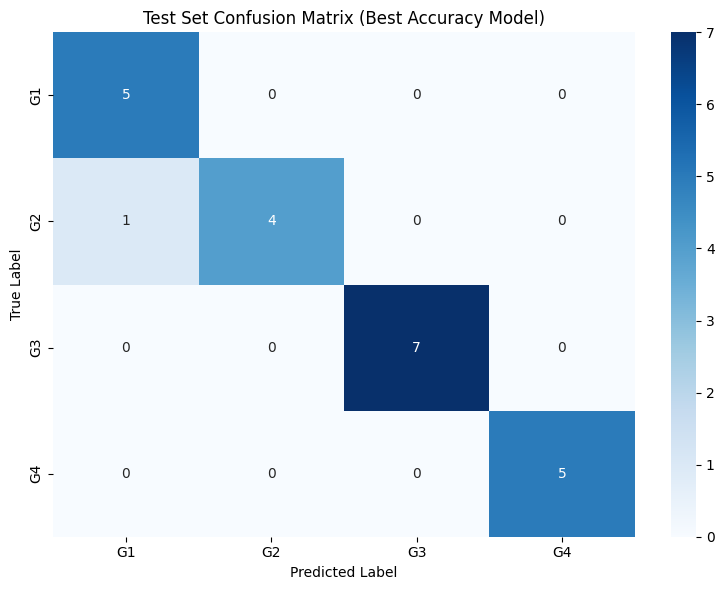

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Initializing dataset...")
full_dataset = EEGDataset(data_root=DATA_ROOT, fixed_sequence_length=FIXED_SEQUENCE_LENGTH)

if not full_dataset.eeg_paths:
    print("No data loaded. Exiting.")
    exit()

num_samples = len(full_dataset)
test_size = int(TEST_SPLIT_RATIO * num_samples)
train_size = num_samples - test_size

if train_size <= 0 or test_size <= 0:
    min_samples_needed = int(1 / TEST_SPLIT_RATIO) if TEST_SPLIT_RATIO > 0 else 2
    print(f"Dataset too small for splitting with ratio {TEST_SPLIT_RATIO}. Need at least {min_samples_needed} samples.")
    if num_samples > 0:
            train_dataset = full_dataset
            test_dataset = full_dataset
            print(f"Warning: Using all {num_samples} samples for training and testing due to small dataset size.")
    else:
        print("CRITICAL: Dataset is empty after initialization. Cannot proceed.")
        exit()
else:
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn, num_workers=num_workers, pin_memory=True if device.type=='cuda' else False)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, num_workers=num_workers, pin_memory=True if device.type=='cuda' else False)

model = EEG_CNN_LSTM(num_classes=NUM_CLASSES, num_channels=NUM_CHANNELS, sequence_length=FIXED_SEQUENCE_LENGTH, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6)

best_val_loss = float('inf')
best_val_acc = 0.0
epochs_no_improve_loss = 0
best_model_state_accuracy = None

print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device, eval_type="Validation")

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} => "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
            f"LR: {current_lr:.1e}")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state_accuracy = copy.deepcopy(model.state_dict())
        print(f"*** New best validation accuracy: {best_val_acc:.4f}. Saving model state. ***")

    if val_loss < best_val_loss - EARLY_STOPPING_MIN_DELTA:
        best_val_loss = val_loss
        epochs_no_improve_loss = 0
    else:
        epochs_no_improve_loss += 1

    if epochs_no_improve_loss >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs: validation loss did not improve for {EARLY_STOPPING_PATIENCE} consecutive epochs.")
        print(f"Best validation loss achieved: {best_val_loss:.4f}")
        break

print("\n--- Training Finished ---")
if best_model_state_accuracy:
    print(f"Loading model with best validation accuracy: {best_val_acc:.4f} for final evaluation.")
    model.load_state_dict(best_model_state_accuracy)
    try:
        torch.save(best_model_state_accuracy, MODEL_SAVE_PATH)
        print(f"Model with best validation accuracy saved to {MODEL_SAVE_PATH}")
    except Exception as e:
        print(f"Error saving model: {e}")
else:
    print("No best model state recorded.")

print("\n--- Evaluating on Test Set (with best accuracy model) ---")
test_loss, test_acc, true_labels, predicted_labels = evaluate_model(model, val_loader, criterion, device, eval_type="Test")
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f} (from model that had best val_acc: {best_val_acc:.4f})")

if true_labels and predicted_labels:
    class_names = [f"G{i+1}" for i in range(NUM_CLASSES)]
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0))

    cm = confusion_matrix(true_labels, predicted_labels)
    plot_confusion_matrix(cm, class_names=class_names, title="Test Set Confusion Matrix (Best Accuracy Model)")
else:
    print("Could not generate classification report or confusion matrix (no evaluation results).")

## Model Architecture and Citations

The model implemented is a hybrid deep learning architecture combining:

1. **Convolutional Neural Networks (CNNs)**: Specifically, 1D CNNs are used for initial feature extraction from the EEG channels.
2. **Long Short-Term Memory (LSTM) Networks**: Following the CNN layers, an LSTM network models temporal dependencies in the sequence of features.

Citations:
- LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). *Gradient-based learning applied to document recognition.* Proceedings of the IEEE, 86(11), 2278-2324.
- Hochreiter, S., & Schmidhuber, J. (1997). *Long short-term memory.* Neural computation, 9(8), 1735-1780.